# Part 1 ‐ Exploratory data analysis





The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.



In [1]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import numpy as np

import os
import matplotlib.pyplot as plt
import datetime

from matplotlib import rcParams
import matplotlib as mpl

In [2]:
# load as Pandas dataframe
df = pd.read_json('logins.json')
df.head(5)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
type(df['login_time'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [4]:
df = df.set_index(['login_time'])
# add 'count' column
df['count'] = 0
df = df.resample('15T').count()
df = df.reset_index()
df.head()

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


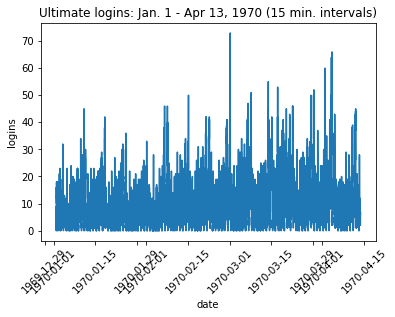

In [5]:
# histogram
plt.plot(df['login_time'], df['count'])
plt.xticks(rotation = 45)
plt.xlabel('date')
plt.ylabel('logins')
plt.title('Ultimate logins: Jan. 1 - Apr 13, 1970 (15 min. intervals)');
plt.show()

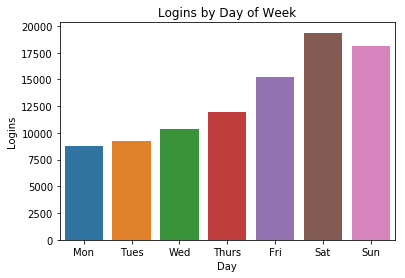

In [6]:
# break logins into days of week
df['day_of_week'] = df.login_time.dt.dayofweek

# sort by count
df_wkd = df.sort_values(by = 'count', ascending = False)

# extract the day of week and count, then group by day and sum all logins
df_wkd = df_wkd[['day_of_week', 'count']]
df_wkd = df_wkd.groupby('day_of_week').sum().reset_index()

# names for ease of reference
df_wkd.day_of_week = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

# bar plot
sns.barplot(x = 'day_of_week', y = 'count', data = df_wkd)
plt.xlabel('Day')
plt.ylabel('Logins')
plt.title('Logins by Day of Week');
plt.show()

In [7]:
df['hour'] = df.login_time.dt.hour
hours = df[['hour', 'count']]
hours = hours.groupby('hour').sum().reset_index()

# Monday
mon = df[df.day_of_week == 0]

# create a new df to highlight logins by hour, weekends only
mon_hours = mon[['hour', 'count']]
mon_hours = mon_hours.groupby('hour').sum().reset_index()
mon_hours.head()

,hour,count
0,0,531
1,1,414
2,2,312
3,3,236
4,4,206


In [17]:
week_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',  'Sunday']


In [18]:
for index, i in  enumerate(week_day):
    print(index, i)

0 Monday
1 Tuesday
2 Wednesday
3 Thursday
4 Friday
5 Saturday
6 Sunday


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/anaconda3/lib/pytho

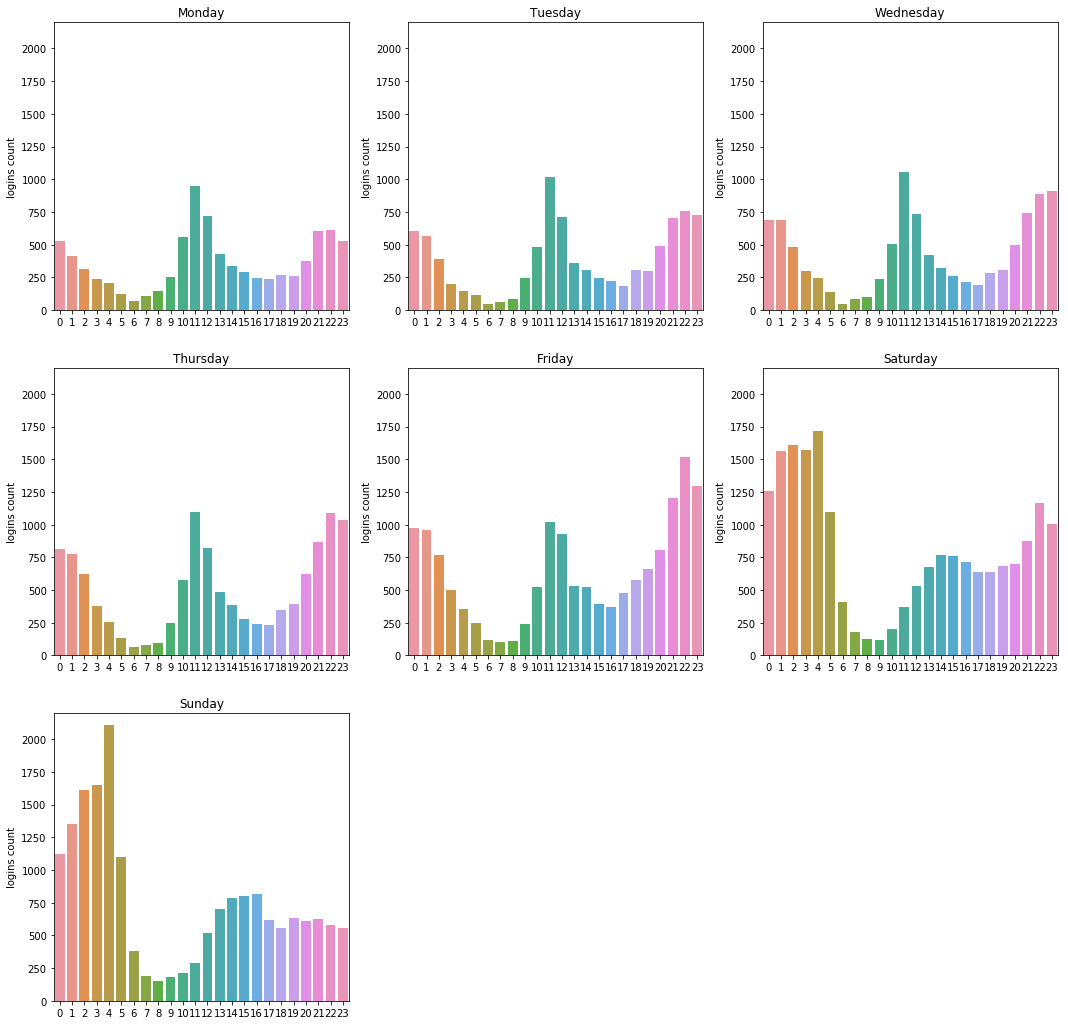

In [19]:
fig = plt.figure(figsize = (18,18))
for index, i in  enumerate(week_day):
    i = df[df.day_of_week == index]
    mon_hours = i[['hour', 'count']]
    mon_hours = mon_hours.groupby('hour').sum().reset_index()
    ax = fig.add_subplot(3,3,index+1)
    sns.barplot(x = 'hour', y = 'count', data = mon_hours)
    plt.xlabel('')
    plt.ylabel('logins count')
    plt.ylim(ymax = 2200)
    plt.title(week_day[index])
plt.show()


By far, the busiest times are early Saturday & Sunday mornings. People are going out and leaving the driving to someone else, which is great for everyone.

There are much smaller peaks during the nights and early mornings every day of the week.

There are also peaks around lunch Mondays - Fridays and steady logins during the afternoons and evenings on Saturdays and Sundays.



# Part 2 ‐ Experiment and metrics design


The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

The only reason for reimbursing tolls would be to increase driver availability levels to reduce wait times for users. The intended consequence is that more users would take more trips more often and that the income to the company would exceed the costs of reimbursing the tolls.

The key measure of success would be Ultimate's income after subtracting out the cost of paying for the tolls. Other indicators would be the number of drivers available for pickups at all times, the number of trips across the toll bridge, and the mean time between a user requesting a car and pickup.

I would recommend performing an A/B test wherein a portion of the drivers are offered reimbursement and the remaining drivers continue to operate without being reimbursed for tolls. This will allow us to control for factors such as a general growth in popularity of our service as well as seasonal changes in ridership while testing. I would perform a 
t
−
t
e
s
t
 with a confidence level of 95%, where the null hypothesis is the reimbursing drivers for tolls does not have a statistically-significant impact on Ultimate's net profits.

I would also suggest that this test may not be entirely dispositive. The danger is that once toll reimbursements are extended to all drivers, the pool of available drivers may become saturated and cause some drivers to stop driving, again increasing wait times and causing users to use a different service.


# Part 3: Predictive Modeling



Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

In [20]:
import json

file = open('ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [22]:
# rating by driver
df.avg_rating_by_driver = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver).mean()
df.avg_rating_of_driver = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver).mean()
df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [23]:
df.phone = df.phone.fillna('iPhone')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [24]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


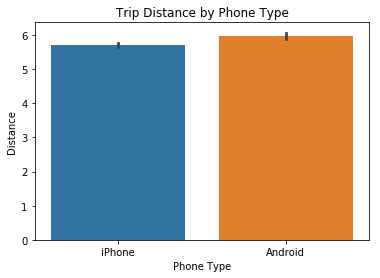

In [25]:
# dist by phone
sns.barplot(x='phone', y='avg_dist', data=df)
plt.ylabel('Distance')
plt.xlabel('Phone Type')
plt.title('Trip Distance by Phone Type');
plt.show()

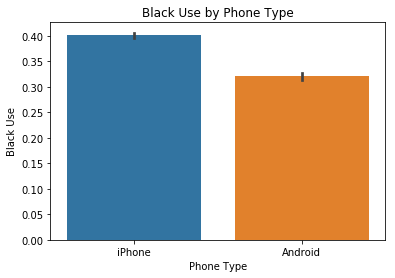

In [26]:
# black by phone
sns.barplot(x='phone', y='ultimate_black_user', data=df)
plt.ylabel('Black Use')
plt.xlabel('Phone Type')
plt.title('Black Use by Phone Type');

In [27]:
active = df[df.last_trip_date >= '2014-06-01 00:00:00']
active.head()
len(active)

18804

In [28]:
# mark users 'retained' in main df if rode in last 30 days
df['retained'] =  df.last_trip_date >= '2014-06-01 00:00:00'
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,4.778158,4.601559,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,4.778158,4.601559,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,4.778158,4.601559,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,False
3,2.36,4.778158,4.601559,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.778158,4.601559,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,False


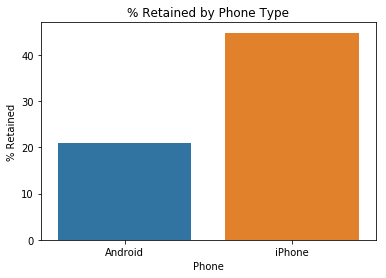

In [30]:
ph_ret = df[['retained', 'phone']].groupby('phone').sum().reset_index()
ph_ret

all_android = df[df.phone == 'Android'].phone.count()
all_android

all_iphone = df[df.phone == 'iPhone'].phone.count()
all_iphone

ph_ret['percent'] = 0

ph_ret.iloc[0, 2] = ph_ret.loc[0, 'retained'] / all_android * 100
ph_ret.iloc[1, 2] = ph_ret.loc[1, 'retained'] / all_iphone * 100

ph_ret
sns.barplot(x = 'phone', y = 'percent', data = ph_ret)
plt.xlabel('Phone')
plt.ylabel('% Retained')
plt.title('% Retained by Phone Type');

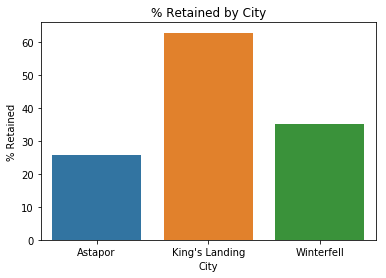

In [31]:
city = df[['retained', 'city']].groupby('city').sum().reset_index()

city_total = df[['retained', 'city']].groupby('city').count().reset_index()

city = city.merge(city_total, on = 'city')
city.columns = ['city', 'retained', 'total']
city['percent'] = city.retained / city.total * 100
city

sns.barplot(x = 'city', y = 'percent', data = city)
plt.xlabel('City')
plt.ylabel('% Retained')
plt.title('% Retained by City');

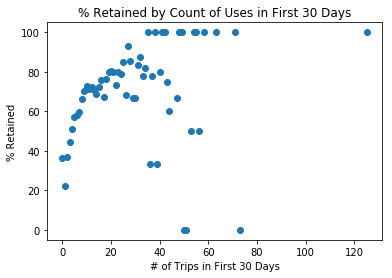

In [32]:
early = df[['retained', 'trips_in_first_30_days']].groupby('trips_in_first_30_days').sum().reset_index()

early_total = df[['retained', 'trips_in_first_30_days']].groupby('trips_in_first_30_days').count().reset_index()

early = early.merge(early_total, on = 'trips_in_first_30_days')
early
early.columns = ['trips_in_first_30_days', 'retained', 'total']
early['percent'] = early.retained / early.total * 100
early

plt.scatter(early['trips_in_first_30_days'], early['percent'])
plt.xlabel('# of Trips in First 30 Days')
plt.ylabel('% Retained')
plt.title('% Retained by Count of Uses in First 30 Days');

In [33]:
df = df.drop(['last_trip_date', 'signup_date'], axis = 1)
df = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])
df

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,3.67,4.778158,4.601559,1.10,15.4,4,46.2,True,0,1,0,0,1,0,1
1,8.26,4.778158,4.601559,1.00,0.0,0,50.0,False,1,0,0,1,0,1,0
2,0.77,4.778158,4.601559,1.00,0.0,3,100.0,False,1,0,0,0,1,1,0
3,2.36,4.778158,4.601559,1.14,20.0,9,80.0,True,0,1,0,0,1,0,1
4,3.13,4.778158,4.601559,1.19,11.8,14,82.4,False,0,0,1,1,0,1,0
5,10.56,4.778158,4.601559,1.00,0.0,2,100.0,True,0,0,1,0,1,0,1
6,3.95,4.778158,4.601559,1.00,0.0,1,100.0,False,1,0,0,1,0,1,0
7,2.04,4.778158,4.601559,1.00,0.0,2,100.0,False,0,0,1,0,1,1,0
8,4.36,4.778158,4.601559,1.00,0.0,2,100.0,False,0,0,1,1,0,1,0
9,2.37,4.778158,4.601559,1.00,0.0,1,0.0,False,0,0,1,1,0,1,0


In [34]:
y = df.retained
df = df.drop('retained', axis = 1)
df = df.join(y)
df

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True,retained
0,3.67,4.778158,4.601559,1.10,15.4,4,46.2,0,1,0,0,1,0,1,True
1,8.26,4.778158,4.601559,1.00,0.0,0,50.0,1,0,0,1,0,1,0,False
2,0.77,4.778158,4.601559,1.00,0.0,3,100.0,1,0,0,0,1,1,0,False
3,2.36,4.778158,4.601559,1.14,20.0,9,80.0,0,1,0,0,1,0,1,True
4,3.13,4.778158,4.601559,1.19,11.8,14,82.4,0,0,1,1,0,1,0,False
5,10.56,4.778158,4.601559,1.00,0.0,2,100.0,0,0,1,0,1,0,1,True
6,3.95,4.778158,4.601559,1.00,0.0,1,100.0,1,0,0,1,0,1,0,False
7,2.04,4.778158,4.601559,1.00,0.0,2,100.0,0,0,1,0,1,1,0,False
8,4.36,4.778158,4.601559,1.00,0.0,2,100.0,0,0,1,1,0,1,0,False
9,2.37,4.778158,4.601559,1.00,0.0,1,0.0,0,0,1,1,0,1,0,False


In [35]:
from sklearn import preprocessing

# create scaler
scaler = preprocessing.StandardScaler()

# select columns to scale
cols = df.columns.tolist()
cols_to_scale = cols[:7]
cols_to_scale

# transform numeric stats
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

df.head()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True,retained
0,-0.372650,1.0,0.0,0.113506,0.328202,0.453984,-0.397131,0,1,0,0,1,0,1,True
1,0.431583,1.0,0.0,-0.336268,-0.443394,-0.600689,-0.294653,1,0,0,1,0,1,0,False
2,-0.880771,1.0,0.0,-0.336268,-0.443394,0.190316,1.053741,1,0,0,0,1,1,0,False
3,-0.602181,1.0,0.0,0.293416,0.558679,1.772325,0.514383,0,1,0,0,1,0,1,True
4,-0.467266,1.0,0.0,0.518303,0.147829,3.090665,0.579106,0,0,1,1,0,1,0,False


In [39]:
# sklearn imports
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

data = df

# set random_state SEED variable
SEED = 42



In [41]:
# import data and split into features matrix and target vector


X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# training set breakdown
train_success = y_train.sum()
train_total = len(y_train)
train_percent = train_success / train_total
print('Training Set\nSuccesses:\t{}\nTotal:\t\t{}\nPercent:\t{:.3f}\n'.format(train_success, train_total, train_percent))

# test set breakdown
test_success = y_test.sum()
test_total = len(y_test)
test_percent = test_success / test_total
print('Test Set\nSuccesses:\t{}\nTotal:\t\t{}\nPercent:\t{:.3f}\n\n'.format(test_success, test_total, test_percent))

Training Set
Successes:	13183
Total:		35000
Percent:	0.377

Test Set
Successes:	5621
Total:		15000
Percent:	0.375




Class 0: 31196
Class 1: 18804
Proportion: 2.0 : 1


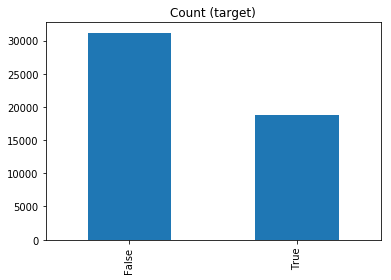

In [42]:
# check for balanced data set

target_count = df.retained.value_counts()
print('Class 0: {}'.format(target_count[0]))
print('Class 1: {}'.format(target_count[1]))
print('Proportion: {}'.format(round(target_count[0] / target_count[1]), 2), ': 1')

target_count.plot(kind='bar', title = 'Count (target)');

Dummy Classifier accuracy: 0.5273


              precision    recall  f1-score   support

       False       0.62      0.63      0.62      9379
        True       0.37      0.36      0.36      5621

   micro avg       0.53      0.53      0.53     15000
   macro avg       0.49      0.49      0.49     15000
weighted avg       0.53      0.53      0.53     15000



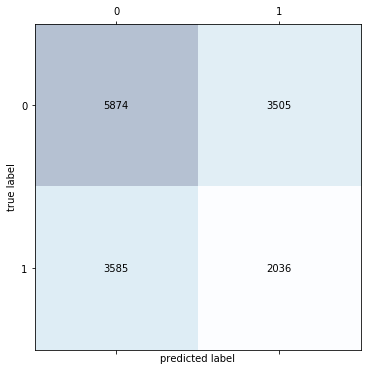

In [44]:
X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

X.shape
y.shape

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# instantiate and fit a dummy classifier
dummy = DummyClassifier(random_state = SEED)
dummy.fit(X_train, y_train)

# make predictions
y_pred = dummy.predict(X_test)

# SCORING
# accuracy
dummy_accuracy = dummy.score(X_test, y_test)
print('Dummy Classifier accuracy: {:.4f}\n\n'.format(dummy_accuracy))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy:	0.7143

              precision    recall  f1-score   support

       False       0.74      0.84      0.79      9379
        True       0.66      0.50      0.57      5621

   micro avg       0.71      0.71      0.71     15000
   macro avg       0.70      0.67      0.68     15000
weighted avg       0.71      0.71      0.70     15000



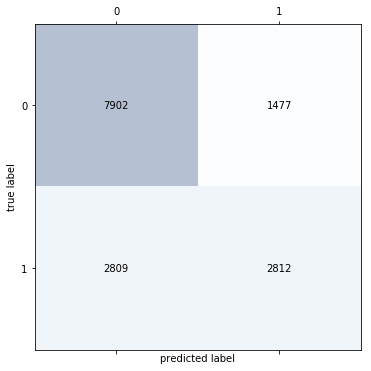

In [46]:
# imports
from sklearn.linear_model import LogisticRegression


X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# instantiate & fit model
model = LogisticRegression(random_state = SEED)
model.fit(X_train, y_train)

# make predictions on test features
y_pred = model.predict(X_test)

# score predictions
accuracy = model.score(X_test, y_test)
print('Logistic Regression Accuracy:\t{:.4f}\n'.format(accuracy))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Best penalty: l2
Best C: 0.01
Tuned Accuracy:	0.7146

              precision    recall  f1-score   support

       False       0.74      0.85      0.79      9379
        True       0.66      0.49      0.56      5621

   micro avg       0.71      0.71      0.71     15000
   macro avg       0.70      0.67      0.68     15000
weighted avg       0.71      0.71      0.70     15000



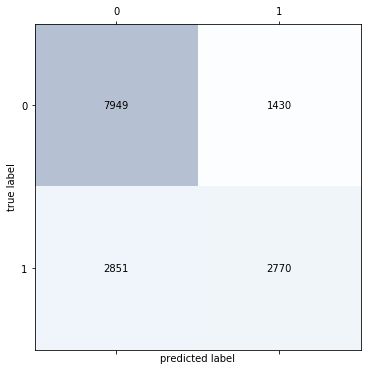

In [47]:
X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# instantiate the learning algorithm
model = LogisticRegression(random_state = SEED)

# create a params dict
penalty = ['l1', 'l2']
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
hyperparameters = dict(C = C, penalty = penalty)

# instantiate & fit grid search
gridsearch = GridSearchCV(model, hyperparameters, cv = 5, verbose = 0)
best_model = gridsearch.fit(X_train, y_train)

# print the best hyperparameters
best_penalty = best_model.best_estimator_.get_params()['penalty']
best_C = best_model.best_estimator_.get_params()['C']
print('Best penalty: {}'.format(best_penalty))
print('Best C: {}'.format(best_C))

# build & fit a tuned model
tuned_model = LogisticRegression(C = best_C, penalty = best_penalty)
tuned_model.fit(X_train, y_train)

# make predictions on test features
y_pred = tuned_model.predict(X_test)

# score predictions
accuracy = tuned_model.score(X_test, y_test)
print('Tuned Accuracy:\t{:.4f}\n'.format(accuracy))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best C: 0.001
Tuned Accuracy:	0.7147

              precision    recall  f1-score   support

       False       0.73      0.86      0.79      9379
        True       0.67      0.47      0.55      5621

   micro avg       0.71      0.71      0.71     15000
   macro avg       0.70      0.67      0.67     15000
weighted avg       0.71      0.71      0.70     15000



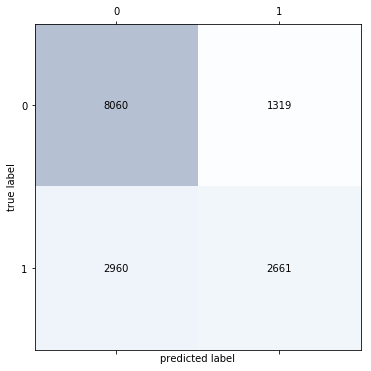

In [49]:
from sklearn.svm import LinearSVC
X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# instantiate and fit the learning algorithm
model = LinearSVC(random_state=SEED)
model.fit(X_train, y_train)

# make predictions on test features
y_pred = model.predict(X_test)

# create a params dict
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
hyperparameters = dict(C = C)

# instantiate & fit grid search
gridsearch = GridSearchCV(model, hyperparameters, cv = 5, verbose = 0)
best_model = gridsearch.fit(X_train, y_train)

# print the best hyperparameters
best_C = best_model.best_estimator_.get_params()['C']
print('Best C: {}'.format(best_C))

# build & fit a tuned model
tuned_model = LinearSVC(C = best_C)
tuned_model.fit(X_train, y_train)

# make predictions on test features
y_pred = tuned_model.predict(X_test)

# score predictions
accuracy = tuned_model.score(X_test, y_test)
print('Tuned Accuracy:\t{:.4f}\n'.format(accuracy))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 0.7147
              precision    recall  f1-score   support

       False       0.73      0.86      0.79      9379
        True       0.67      0.47      0.55      5621

   micro avg       0.71      0.71      0.71     15000
   macro avg       0.70      0.67      0.67     15000
weighted avg       0.71      0.71      0.70     15000



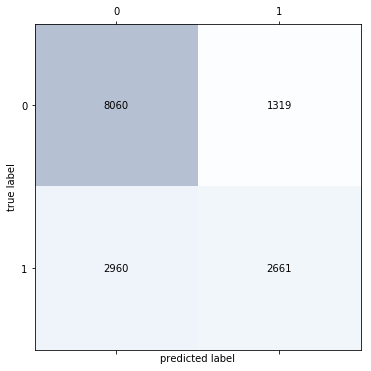

In [50]:
from sklearn.svm import SVC


X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# instantiate the learning algorithm
model = SVC(random_state=SEED)

# create a params dict
model.fit(X_train, y_train)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.4f}'.format(accuracy))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');

              precision    recall  f1-score   support

       False       0.76      0.77      0.76      9379
        True       0.61      0.60      0.60      5621

   micro avg       0.70      0.70      0.70     15000
   macro avg       0.68      0.68      0.68     15000
weighted avg       0.70      0.70      0.70     15000



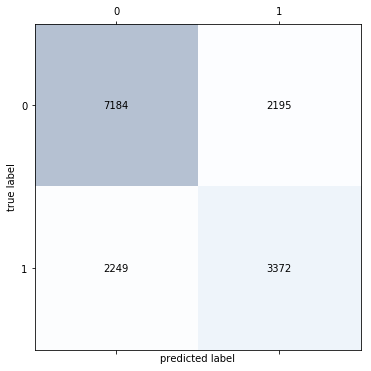

In [52]:
# imports
from sklearn.tree import DecisionTreeClassifier


X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# instantiate & train a DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = SEED)
dt.fit(X_train, y_train)

# make predictions
y_pred = dt.predict(X_test)

# SCORING
# accuracy
accuracy_score(y_test, y_pred)

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');

Best max_depth: 10
Best min_samples_leaf: 0.01
Tuned Decision Tree Accuracy:	0.758
              precision    recall  f1-score   support

       False       0.81      0.81      0.81      9379
        True       0.68      0.67      0.68      5621

   micro avg       0.76      0.76      0.76     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.76      0.76      0.76     15000



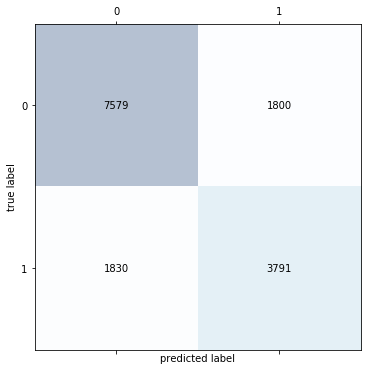

In [54]:
X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# instantiate the learning algorithm
model = DecisionTreeClassifier()

# create a params dict
depth = [2, 3, 4, 5, 6, 10, 15, 20]
min_samples = [.01, .025, .05, .075, .1, .2]
hyperparameters = dict(max_depth = depth, min_samples_leaf = min_samples)

# instantiate grid search
gridsearch = GridSearchCV(model, hyperparameters, cv = 5, verbose = 0)

# fit grid search
best_model = gridsearch.fit(X_train, y_train)

# print the best hyperparameters
best_depth = best_model.best_estimator_.get_params()['max_depth']
best_min_samples = best_model.best_estimator_.get_params()['min_samples_leaf']
print('Best max_depth: {}'.format(best_depth))
print('Best min_samples_leaf: {}'.format(best_min_samples))


# RUN MODEL WITH BEST HYPERPARAMETERS

# instantiate a DecisionTreeClassifier
tuned_model = DecisionTreeClassifier(max_depth = best_depth,
                                     min_samples_leaf = best_min_samples,
                                     random_state = SEED)

# train the model
tuned_model.fit(X_train, y_train)

# make predictions
y_pred = tuned_model.predict(X_test)

# score accuracy
tuned_model_accuracy = accuracy_score(y_test, y_pred)
print('Tuned Decision Tree Accuracy:\t{}'.format(tuned_model_accuracy))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');

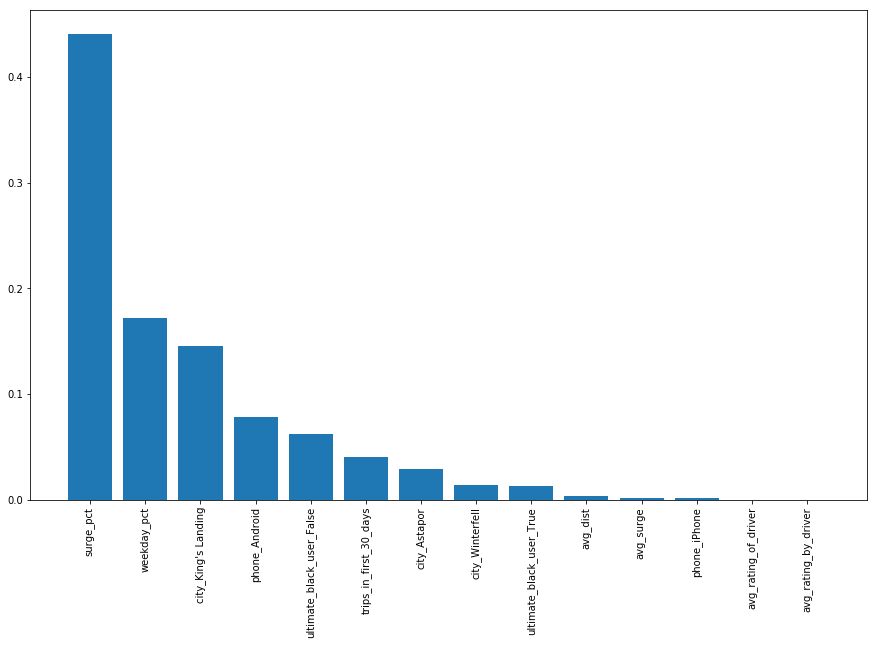

In [55]:
# calculate feature importances
importances = tuned_model.feature_importances_

# sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

plt.figure(figsize = (15, 9))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation = 90);

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

       False       0.77      0.80      0.79      9379
        True       0.65      0.61      0.63      5621

   micro avg       0.73      0.73      0.73     15000
   macro avg       0.71      0.71      0.71     15000
weighted avg       0.73      0.73      0.73     15000



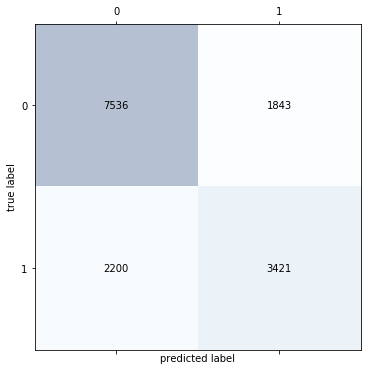

In [56]:
from sklearn.ensemble import RandomForestClassifier

X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# instantiate & fit
model = RandomForestClassifier(random_state = SEED)
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');

Best max_depth: 15
Best min_samples_leaf: 0.01
Best n_estimators: 50
              precision    recall  f1-score   support

       False       0.77      0.88      0.82      9379
        True       0.73      0.57      0.64      5621

   micro avg       0.76      0.76      0.76     15000
   macro avg       0.75      0.72      0.73     15000
weighted avg       0.76      0.76      0.75     15000



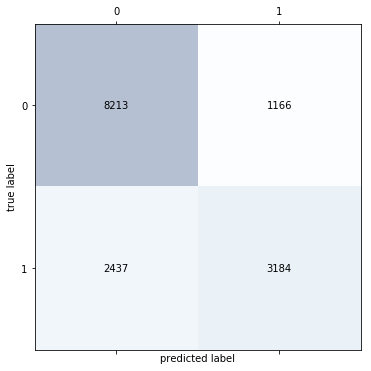

In [57]:
X, y = df[df.columns.tolist()[:-1]], df[df.columns.tolist()[-1]]

# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = SEED)

# instantiate the learning algorithm
model = RandomForestClassifier(random_state = SEED)

# create a params dict
depth = [2, 3, 4, 5, 6, 10, 15, 20]
min_samples = [.01, .025, .05, .075, .1, .2]
est = [5, 10, 50, 100, 500]
hyperparameters = dict(max_depth = depth, 
                       min_samples_leaf = min_samples,
                       n_estimators = est)

# instantiate grid search
gridsearch = GridSearchCV(model, hyperparameters, cv = 5, verbose = 0)

# fit grid search
best_model = gridsearch.fit(X_train, y_train)

# print the best hyperparameters
best_depth = best_model.best_estimator_.get_params()['max_depth']
best_min_samples = best_model.best_estimator_.get_params()['min_samples_leaf']
best_est = best_model.best_estimator_.get_params()['n_estimators']
print('Best max_depth: {}'.format(best_depth))
print('Best min_samples_leaf: {}'.format(best_min_samples))
print('Best n_estimators: {}'.format(best_est))


# BUILD MODEL WITH BEST HYPERPARAMETERS

# instantiate a RandomForestClassifier
tuned_model = RandomForestClassifier(max_depth = best_depth,
                                     min_samples_leaf = best_min_samples,
                                     n_estimators = best_est,
                                     random_state = SEED)

# train the model
tuned_model.fit(X_train, y_train)

# make predictions
tuned_model_y_pred = tuned_model.predict(X_test)

# SCORING
# accuracy
accuracy_score(y_test, tuned_model_y_pred)

# classification report
print(classification_report(y_test, tuned_model_y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = tuned_model_y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');